In [9]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

In [10]:
df=pd.read_csv('./data/data_BNB-USD.csv')
close=df.Close
ret=np.log(close)-np.log(close.shift(1))
ret=ret.dropna()

In [11]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%% First four moments %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
N=len(ret)
mean=sum(ret)/N
std=np.sqrt(sum((ret-mean)**2)/N)
skewness=sum((ret-mean)**3)/(N*std**3)
kurtosis=sum((ret-mean)**4)/(N*std**4)-3
print(f'mean: {mean}, standard deviation: {std}, skewness {skewness}, kurtosis: {kurtosis}')
print(f'mean: {stats.describe(ret)[2]}, standard deviation: {np.sqrt(stats.describe(ret)[3])}, skewness {stats.describe(ret)[4]}, kurtosis: {stats.describe(ret)[5]}')


mean: -7.671020315675249e-06, standard deviation: 0.0015454785238368468, skewness -0.34009155662516954, kurtosis: 6.296450579486603
mean: -7.671020315675249e-06, standard deviation: 0.0015457768499710484, skewness -0.34009155662516877, kurtosis: 6.296450579486574


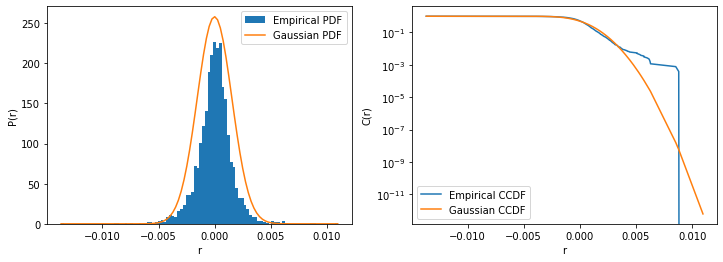

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%% Plot of empirical PDF vs Gaussian %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
x = np.linspace(min(ret),max(ret),100)
#Gaussian PDF values computed on point grid
g = np.exp(-(x-mean)**2/(2*std**2))/np.sqrt(2*np.pi*std**2)
ax[0].hist(ret,bins=100,label='Empirical PDF')
ax[0].plot(x,g,label='Gaussian PDF')
ax[0].set_xlabel('r')
ax[0].set_ylabel('P(r)')
ax[0].legend()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%% Plot of empirical CCDF vs Gaussian %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
x=np.array(sorted(ret))
y=np.linspace(1,len(ret)+1,len(ret))
#Calculating CCDF as rank-frequency plot
y=1-y/(len(ret)+1)
#Gaussian CCDF
c = 0.5*(1 - sp.special.erf((x-mean)/(std*np.sqrt(2))))
ax[1].semilogy(x,y,label='Empirical CCDF')
ax[1].semilogy(x,c,label='Gaussian CCDF')
ax[1].set_xlabel('r')
ax[1].set_ylabel('C(r)')
ax[1].legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Right tail exponent: 2.50496786073062
Left tail exponent: 2.2758632050570484


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


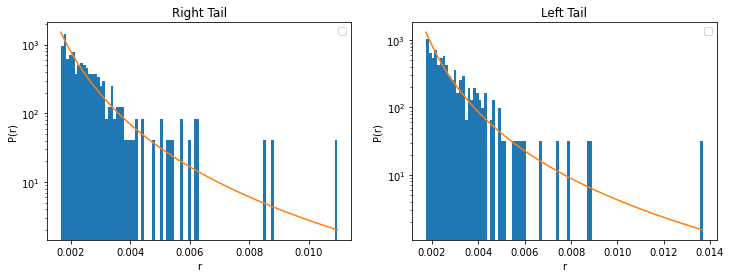

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%% Fitting right & left tail via Maximum Likelihood %%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
p = 0.1 # Defining tails as top p% of returns (both positive and negative)

#%%% Right tail %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
r=sorted(ret)
r_right = np.array(r[round((1-p)*len(r)):])
N=len(r_right)
alpha_right=N/sum(np.log(r_right/min(r_right))) # Maximum-likelihood estimate for right tail exponent
print(f'Right tail exponent: {alpha_right}')

x_right = np.linspace(min(r_right),max(r_right),100) #Grid of points between min and max values in right tail
y_right = alpha_right*(x_right/min(r_right))**(-alpha_right-1)/min(r_right) # Values of power law distribution on grid of points

ax[0].hist(r_right,100,density=True, stacked=True)
ax[0].semilogy(x_right,y_right)
ax[0].set_xlabel('r')
ax[0].set_ylabel('P(r)')
ax[0].set_title('Right Tail')
ax[0].legend()
#%%% left tail %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
r=sorted(ret)
r_left = np.array(r[:round((p)*len(r))])
r_left=abs(r_left)
N=len(r_left)
alpha_left=N/sum(np.log(r_left/min(r_left))) # Maximum-likelihood estimate for left tail exponent
print(f'Left tail exponent: {alpha_left}')

x_left = np.linspace(min(r_left),max(r_left),100) #Grid of points between min and max values in left tail
y_left = alpha_left*(x_left/min(r_left))**(-alpha_left-1)/min(r_left) # Values of power law distribution on grid of points

ax[1].hist(r_left,100,density=True, stacked=True)
ax[1].semilogy(x_left,y_left)
ax[1].set_xlabel('r')
ax[1].set_ylabel('P(r)')
ax[1].set_title('Left Tail')
ax[1].legend()

plt.show()

Right tail interval at 0.9 CL: [2.3770361059825578; 2.609811712041557]
Left tail interval at 0.9 CL: [2.1844899879228574; 2.3874314979215563]


Text(0.5, 1.0, 'Boostrap tail exponent values')

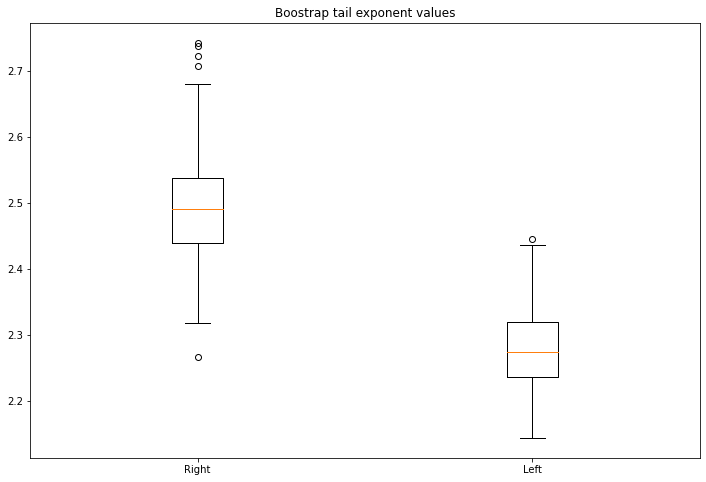

In [18]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%% Bootstrap analysis %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
bts = 0.8 # Fraction of data to be retained in each bootstrap sample
Nbts = 500 # Number of bootstrap samples
alpha = 0.9 # Significance level

# %%% Right tail with bootstrap %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

alpha_right_bts = [] #  Vector to collect bootstrap estimates for right tail exponent
for i in range(1, Nbts+1):
    r=ret
    np.random.shuffle(r.values) # Random permutation of returns
    r_bts = r[1:round(bts*len(r))] # Bootstrapping bts% of returns 
    r_bts = sorted(r_bts) # Sorting bootstrapped returns
    r_right_bts = np.array(r_bts[round((1-p)*len(r_bts)):]) # Selecting top p% of returns
    
    N_bts = len(r_right_bts) # Number of bootstrapped returns
    alpha_right_bts.append(N_bts/sum(np.log(r_right_bts/min(r_right_bts))));
    
alpha_right_bts = sorted(alpha_right_bts) # Sorting bootstrap estimates for right tail exponent

print(f'Right tail interval at {alpha} CL: [{alpha_right_bts[round(0.5*(1-alpha)*Nbts)]}; {alpha_right_bts[round(0.5*(1+alpha)*Nbts)]}]')

#%%% Left tail with bootstrap %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

alpha_left_bts = [] #  Vector to collect bootstrap estimates for left tail exponent
for i in range(1, Nbts+1):
    r=ret
    np.random.shuffle(r.values) # Random permutation of returns
    r_bts = r[1:round(bts*len(r))] # Bootstrapping bts% of returns 
    r_bts = sorted(r_bts) # Sorting bootstrapped returns
    r_left_bts = np.array(r_bts[:round((p)*len(r_bts))]) # Selecting top p% of returns
    r_left_bts=abs(r_left_bts)
    
    N_bts = len(r_left_bts) # Number of bootstrapped returns
    alpha_left_bts.append(N_bts/sum(np.log(r_left_bts/min(r_left_bts))));
    
alpha_left_bts = sorted(alpha_left_bts) # Sorting bootstrap estimates for left tail exponent

print(f'Left tail interval at {alpha} CL: [{alpha_left_bts[round(0.5*(1-alpha)*Nbts)]}; {alpha_left_bts[round(0.5*(1+alpha)*Nbts)]}]')

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.boxplot([alpha_right_bts,alpha_left_bts])
my_xticks = ['Right','Left']
plt.xticks([1,2], my_xticks)
ax.set_title('Boostrap tail exponent values')

0.004_0.0011_-0.002_0.008_0.002


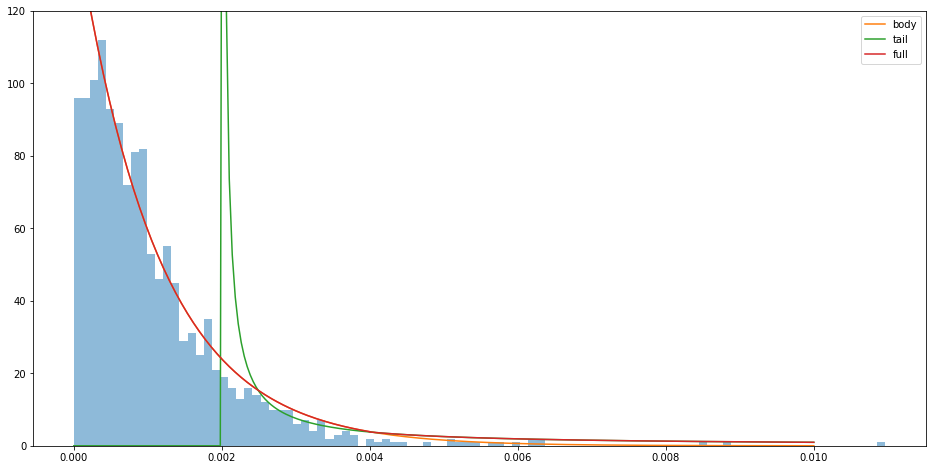

In [19]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%% Calibration of body + tail of distribution %%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#%%% Here we calibrate via maximum likelihood an exponential distribution 
#%%% for the body and a power law distribution for the tail of the returns'
#%%% empirical distribution

ret_pos=ret[ret>0]
ret_neg=ret[ret<0]

penalty=100
log_likelihood = lambda threshold, exp_scale, exp_loc, power_a, power_loc: \
                                                        sum([np.log(stats.expon.pdf(v, scale=exp_scale,loc=exp_loc)) for v in ret_pos[ret_pos<=threshold]])+\
                                                        sum([np.log(stats.powerlaw.pdf(v, a=power_a,loc=power_loc)) for v in ret_pos[ret_pos>threshold]])-\
                                                        penalty*(stats.expon.pdf(threshold, scale=exp_scale,loc=exp_loc)-stats.powerlaw.pdf(threshold, a=power_a,loc=power_loc))**2

exp_scale = np.arange(0.0010, 0.0012, 0.0001)
exp_loc = np.arange(-0.003, -0.001, 0.001)
power_a=np.arange(0.006,0.009,0.001)
power_loc=np.arange(0.001,0.003,0.001)
threshold=np.arange(0.003,0.005,0.001)

result_dict={}

for e_s in exp_scale:
    for e_l in exp_loc:
        for p_a in power_a:
            for p_l in power_loc:
                for t in threshold:
                    ll=log_likelihood(t,e_s, e_l, p_a,p_l)
                    title=str(f'{t}_{e_s}_{e_l}_{p_a}_{p_l}')
                    result_dict[title]=ll
print(max(result_dict, key=result_dict.get))

plt.subplots(figsize=(16,8))
x1=np.linspace(0,0.004,100)
x2=np.linspace(0.004,0.01,100)
plt.hist(ret_pos,bins=100,alpha=0.5)
plt.plot(list(x1)+list(x2),list(stats.expon.pdf(list(x1)+list(x2),scale=0.0011,loc=-0.002)),label='body',alpha=1)
plt.plot(list(x1)+list(x2),list(stats.powerlaw.pdf(list(x1)+list(x2),a=0.008,loc=0.002)),label='tail',alpha=1)
plt.plot(list(x1)+list(x2),list(stats.expon.pdf(x1,scale=0.0011,loc=-0.002))+list(stats.powerlaw.pdf(x2 ,a=0.008,loc=0.002)),label='full')
plt.ylim([0,120])
plt.legend()
plt.show()
